<a href="https://www.kaggle.com/code/profitrolka20/titanic5?scriptVersionId=203511433" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Dropout - это техника регуляризации, которая помогает предотвратить переобучение нейронной сети. Вот основные причины его применения:

# 1) Предотвращает переобучение: Dropout случайным образом отключает некоторые нейроны во время обучения, что заставляет сеть учиться 
#более общим представлениям данных.

# 2) Улучшает обобщающую способность: Сеть становится менее зависимой от отдельных нейронов и учится работать с различными комбинациями 
#активированных нейронов.

# 3) Эффективно работает как ансамбль моделей: При каждой эпохе обучения создается "новая" модель, что эквивалентно усреднению 
#множества моделей.

In [2]:
#Kernel regularization - это метод регуляризации весов нейрона или слоя. Основная цель:

# 1) Ограничивает рост весов: Регуляризация добавляет штраф к функции потерь за большие значения весов.

# 2) Предотвращает переобучение: Меньшие веса обычно приводят к более простым решениям, которые лучше обобщаются.

#3) Улучшает интерпретируемость: Меньшие веса могут сделать модель более понятной.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import re

# Загрузка данных, считываем датасет для работы с ним
titanic_df = pd.read_csv('/kaggle/input/titanic2/Titanic.csv')

In [4]:
#Датасет состоит из 891 записи с 12 признаками. Ключевые столбцы:

# Survived: целевая переменная, указывающая, выжил ли пассажир (1 — да, 0 — нет).
# Pclass: класс билета (1-й, 2-й, 3-й).
# Sex: пол пассажира.
# Age: возраст (есть пропуски).
# SibSp: количество братьев/сестёр или супругов на борту.
# Parch: количество родителей/детей на борту.
# Fare: стоимость билета.
# Cabin: номер каюты (с множеством пропусков).
# Embarked: порт посадки (C, Q, S).

In [5]:
# Feature Engineering - придумать новые признаки

# Извлечение титула (Title) из имени (Name)
def extract_title(name):
    match = re.search(r',\s(\w+)\.', name)
    if match:
        return match.group(1)
    return 'Unknown'

# Применяем функцию к столбцу 'Name'. Извлечём из имени пассажира (например, Mr., Mrs., Miss. и т.д.).
titanic_df['Title'] = titanic_df['Name'].apply(extract_title)

# Признак семьи или одиночества
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 0).astype(int)

# Извлечение префикса билета
titanic_df['TicketPrefix'] = titanic_df['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'None')

# Рассчитываем стоимость билета на одного человека
titanic_df['FarePerPerson'] = titanic_df['Fare'] / (titanic_df['FamilySize'] + 1)

# Извлекаем палубу из номера каюты
titanic_df['Deck'] = titanic_df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'U')

# Признак возраста в возрастные группы
titanic_df['AgeGroup'] = pd.cut(titanic_df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

# Теперь вы можете вывести итоговые данные
print(titanic_df[['Title', 'FamilySize', 'IsAlone', 'TicketPrefix', 'FarePerPerson', 'Deck', 'AgeGroup']].head())


  Title  FamilySize  IsAlone TicketPrefix  FarePerPerson Deck     AgeGroup
0    Mr           1        0          A/5        3.62500    U  Young Adult
1   Mrs           1        0           PC       35.64165    C        Adult
2  Miss           0        1     STON/O2.        7.92500    U  Young Adult
3   Mrs           1        0         None       26.55000    C  Young Adult
4    Mr           0        1         None        8.05000    U  Young Adult


In [6]:
# Преобразование категориальных данных
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic_df['Title'], _ = pd.factorize(titanic_df['Title'])
titanic_df['Deck'] = titanic_df['Deck'].map({letter: idx for idx, letter in enumerate(sorted(titanic_df['Deck'].unique()))})

In [7]:
# Заполнение пропусков
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Fare'].fillna(titanic_df['Fare'].median(), inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

/tmp/ipykernel_17/2204507553.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
/tmp/ipykernel_17/2204507553.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

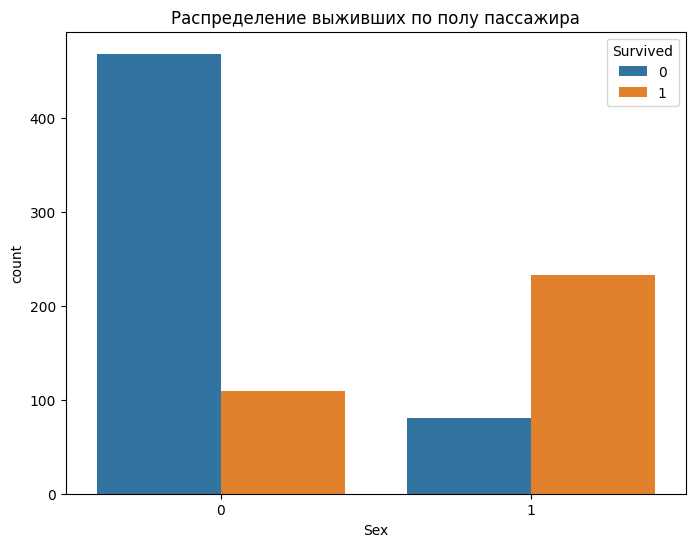

In [8]:
# 1. График распределения выживших по полу
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Survived', data=titanic_df)
plt.title('Распределение выживших по полу пассажира')
plt.show()

In [9]:
# ВЫВОД: Женщины имели значительно больше шансов на выживание. Большинство мужчин погибли, тогда как выживших женщин больше.

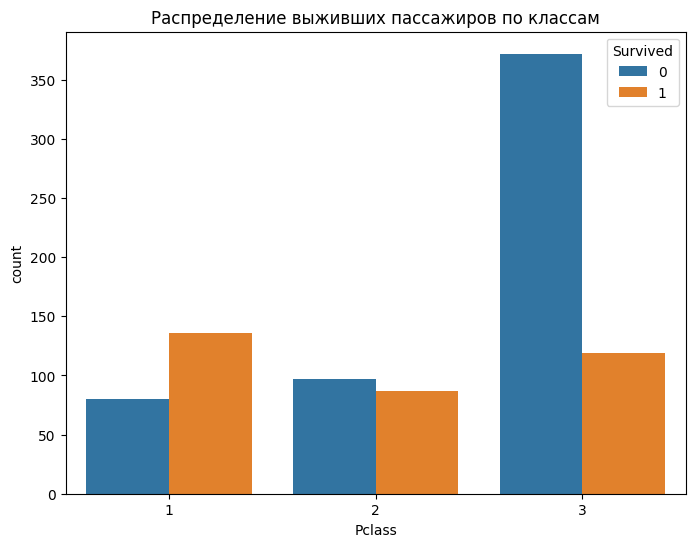

In [10]:
# 2. График распределения пассажиров по классам
plt.figure(figsize=(8, 6))
sns.countplot(x='Pclass', hue='Survived', data=titanic_df)
plt.title('Распределение выживших пассажиров по классам')
plt.show()

In [11]:
# ВЫВОД: Пассажиры 1-го класса имели больше шансов выжить, чем пассажиры 3-го класса. В 3-м классе погибло значительно больше людей.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

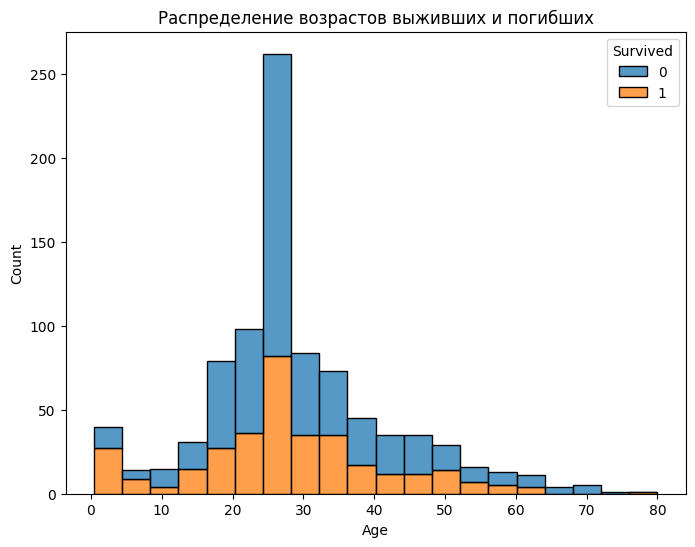

In [12]:
# 3. График распределения возрастов выживших и погибших
plt.figure(figsize=(8, 6))
sns.histplot(data=titanic_df, x='Age', hue='Survived', multiple='stack', bins=20)
plt.title('Распределение возрастов выживших и погибших')
plt.show()

In [13]:
# ВЫВОД:Среди выживших большее количество молодых пассажиров.
# Погибшие охватывают более широкий возрастной диапазон.

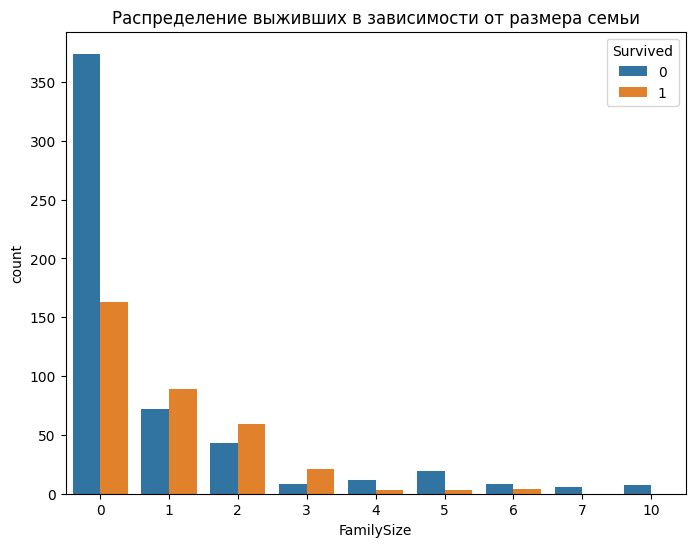

In [14]:
# 4. Размеры семей выживших и погибших
plt.figure(figsize=(8, 6))
sns.countplot(x='FamilySize', hue='Survived', data=titanic_df)
plt.title('Распределение выживших в зависимости от размера семьи')
plt.show()

In [15]:
# ВЫВОД:размер семьи может оказывать значительное влияние на выживаемость. Этот фактор может быть связан с тем, 
#как во время катастрофы организовывалось спасение, а также с тем, как пассажиры помогали друг другу.
#Меньшие семьи имели больше шансов на спасение.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

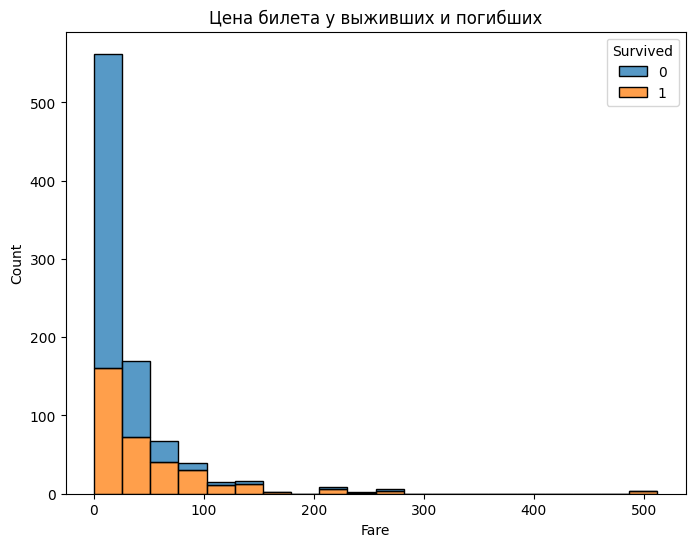

In [16]:
# 5. Цена билета у выживших и погибших
plt.figure(figsize=(8, 6))
sns.histplot(data=titanic_df, x='Fare', hue='Survived', multiple='stack', bins=20)
plt.title('Цена билета у выживших и погибших')
plt.show()

In [17]:
# ВЫВОД: 
#Низкие цены: видно, что количество погибших значительно превышает количество выживших. 
#Это может указывать на то, что пассажиры с низкими ценами билетов (возможно, из низших классов) 
#имели меньшие шансы на выживание.
#Средние: выжившие составляют значительную часть. Особенно заметно, что среди пассажиров, 
#заплативших высокие цены, гораздо больше выживших, что может указывать на то, что более состоятельные 
#пассажиры, скорее всего, находились в лучших условиях и имели больше шансов на спасение.
#Высокие цены: График может также показывать, что пассажиры с очень высокими ценами билетов 
#(например, выше 100) имели вероятность выживания 50 на 50. 

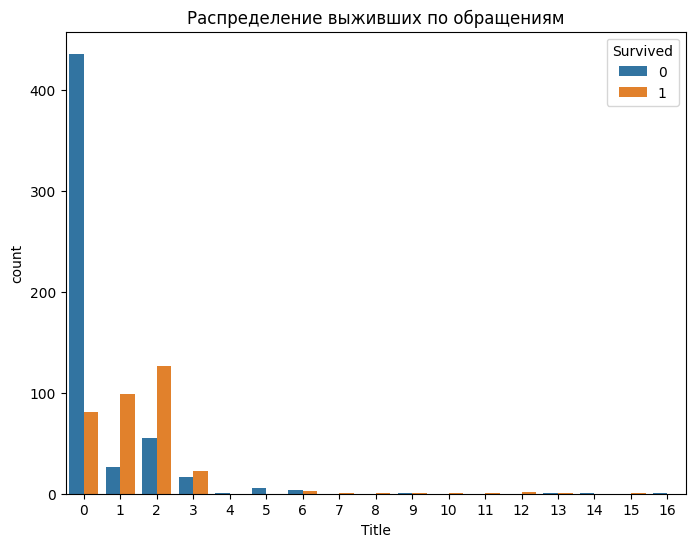

In [18]:
# 6. Распределение выживших по обращениям (Title)
plt.figure(figsize=(8, 6))
sns.countplot(x='Title', hue='Survived', data=titanic_df)
plt.title('Распределение выживших по обращениям')
plt.show()

In [19]:
# ВЫВОД:выживаемость зависела от социальных норм и ожиданий того времени. Женщины и дети чаще выживали, 
#что также подтверждается историческими данными о том, что во время катастрофы на корабле акцентировалось 
#внимание на спасении женщин и детей.

<Figure size 1000x800 with 0 Axes>

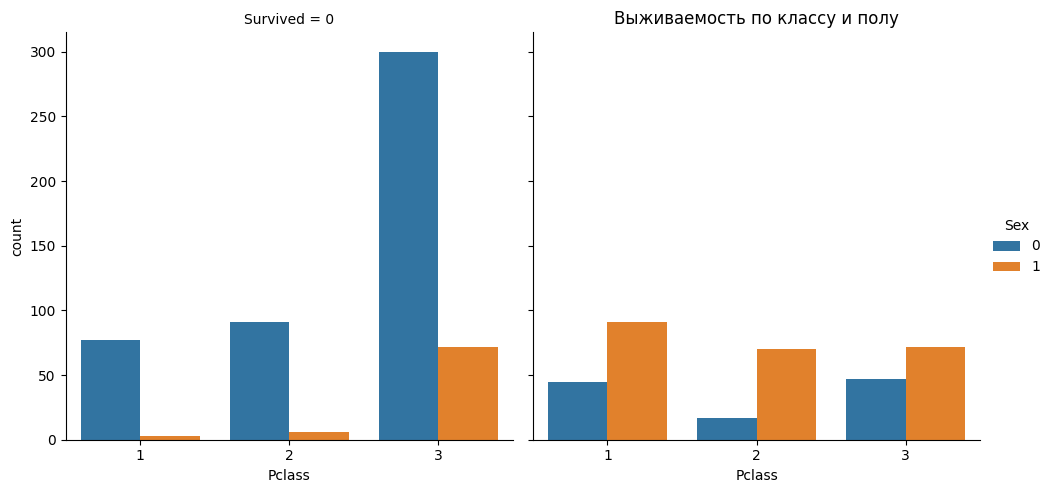

In [20]:
# 7. Зависимость выживаемости от класса билета и пола
plt.figure(figsize=(10, 8))
sns.catplot(x='Pclass', hue='Sex', col='Survived', data=titanic_df, kind='count')
plt.title('Выживаемость по классу и полу')
plt.show()

In [21]:
# ВЫВОД:класс билета и пол играли важную роль в выживаемости на Титанике. Высокий класс и женский пол значительно увеличивали шансы на выживание.

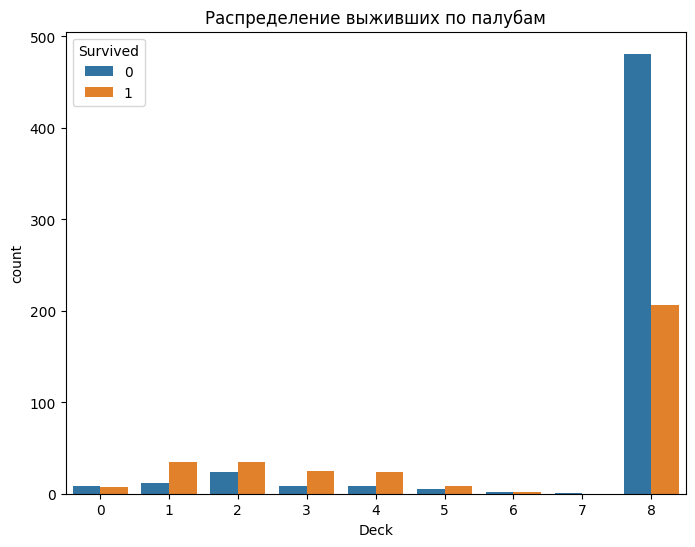

In [22]:
# 8. График распределения по палубам
plt.figure(figsize=(8, 6))
sns.countplot(x='Deck', hue='Survived', data=titanic_df)
plt.title('Распределение выживших по палубам')
plt.show()

In [23]:
# ВЫВОД:
#1,3,4 - высокая выживаемость, преобладает над погибшими. Пассажиры, находившиеся на этих палубах, скорее всего, 
#имели более легкий доступ к спасательным шлюпкам и, возможно, находились в лучших условиях.

#2, 5 - значительное количество выживших.

#6 - 50/50

# 0, 7, 8 - Это может быть связано с тем, что эти палубы были расположены ниже и имели меньший доступ к спасательным шлюпкам.

In [24]:
# Выбираем признаки для модели
X = titanic_df[['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Embarked', 'Title', 'FarePerPerson', 'Deck', 'TicketPrefix']]
y = titanic_df['Survived']

In [25]:
# Преобразуем категориальный признак 'TicketPrefix' в dummy переменные
X = pd.get_dummies(X, columns=['TicketPrefix'], drop_first=True)

# Проверим наличие пропущенных значений
print(X.isnull().sum())

# Если в данных есть пропуски, мы можем их заполнить или удалить
X = X.fillna(0)  # Пример: заполняем пропуски нулями

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Pclass                     0
Sex                        0
Age                        0
Fare                       0
FamilySize                 0
IsAlone                    0
Embarked                   0
Title                      0
FarePerPerson              0
Deck                       0
TicketPrefix_A.5.          0
TicketPrefix_A/4           0
TicketPrefix_A/4.          0
TicketPrefix_A/5           0
TicketPrefix_A/5.          0
TicketPrefix_A/S           0
TicketPrefix_A4.           0
TicketPrefix_C             0
TicketPrefix_C.A.          0
TicketPrefix_C.A./SOTON    0
TicketPrefix_CA            0
TicketPrefix_CA.           0
TicketPrefix_F.C.          0
TicketPrefix_F.C.C.        0
TicketPrefix_Fa            0
TicketPrefix_None          0
TicketPrefix_P/PP          0
TicketPrefix_PC            0
TicketPrefix_PP            0
TicketPrefix_S.C./A.4.     0
TicketPrefix_S.C./PARIS    0
TicketPrefix_S.O./P.P.     0
TicketPrefix_S.O.C.        0
TicketPrefix_S.O.P.        0
TicketPrefix_S

In [26]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [27]:
from keras.regularizers import l2
from keras.layers import Dropout

# Строим нейронную сеть
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))  
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.089)))
model.add(Dropout(0.5))  
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучаем модель
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5839 - loss: 7.7570 - val_accuracy: 0.6425 - val_loss: 5.9828
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - loss: 5.5361 - val_accuracy: 0.7151 - val_loss: 4.2943
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6974 - loss: 4.0068 - val_accuracy: 0.7486 - val_loss: 3.0954
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6997 - loss: 2.9208 - val_accuracy: 0.7654 - val_loss: 2.2493
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7273 - loss: 2.1213 - val_accuracy: 0.7765 - val_loss: 1.6686
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7537 - loss: 1.5802 - val_accuracy: 0.7989 - val_loss: 1.2620
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 1.1914 - val_accuracy: 0.8101 - val_loss: 0.9959
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7898 - loss: 0.9719 - val_accuracy: 0.7989 - val_loss

In [28]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точность модели на тестовых данных: {test_accuracy*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8222 - loss: 0.4904 
Точность модели на тестовых данных: 79.89%


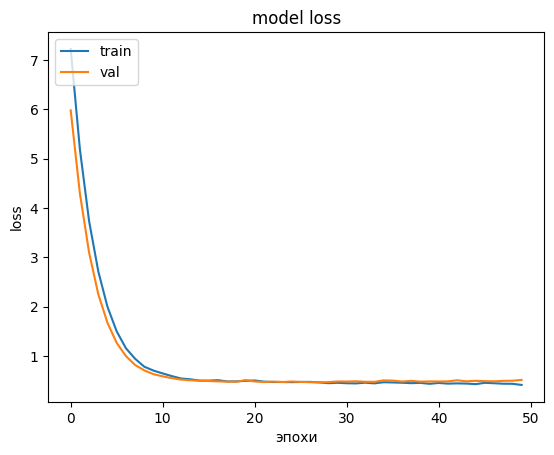

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('эпохи')
plt.legend(loc='upper left')
plt.show()

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

kf = KFold(n_splits=3, shuffle=True, random_state=43)

fold_metrics = []
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    X_test = scaler.transform(X_test)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(f"Fold {fold}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    fold_metrics.append((classification_report(y_test, y_pred, output_dict=True), confusion_matrix(y_test, y_pred)))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       184
           1       0.79      0.73      0.76       113

    accuracy                           0.82       297
   macro avg       0.82      0.81      0.81       297
weighted avg       0.82      0.82      0.82       297

Confusion Matrix:
 [[162  22]
 [ 30  83]]
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       184
           1       0.80      0.81      0.80       113

    accuracy                           0.85       297
   macro avg       0.84      0.84      0.84       297
weighted avg       0.85      0.85      0.85       297

Confusion Matrix:
 [[161  23]
 [ 22  91]]
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3
Classification Report:
               precision    recall  f1-score   supp

**Оценка результатов кросс-валидации для лучшей модели**.

Для каждой из трех фолдов кросс-валидации были получены результаты, которые позволяют оценить производительность модели. На основе данных classification_report и confusion_matrix по каждой из трех фолдов можно сделать следующие выводы:

Интерпретация матрицы ошибок

*1) Fold 1*.
Модель предсказала, что человек погибнет, но фактически он выжил (False Positive) = 12.
Модель предсказала, что человек выживет, но по факту он погиб (False Negative) = 40.
Модель правильно предсказала, что человек выживет (True Positive) = 172.
Модель правильно предсказала, что человек погибнет (True Negative) = 73.

*1) Fold 2*.
Модель предсказала, что человек погибнет, но фактически он выжил (False Positive) = 18.
Модель предсказала, что человек выживет, но по факту он погиб (False Negative) = 26.
Модель правильно предсказала, что человек выживет (True Positive) = 166.
Модель правильно предсказала, что человек погибнет (True Negative) = 87.

*1) Fold 3*.
Модель предсказала, что человек погибнет, но фактически он выжил (False Positive) = 9.
Модель предсказала, что человек выживет, но по факту он погиб (False Negative) = 34.
Модель правильно предсказала, что человек выживет (True Positive) = 172.
Модель правильно предсказала, что человек погибнет (True Negative) = 82.

**Итоговый анализ:**
На основе трех фолдов видно, что модель демонстрирует высокую точность, особенно при предсказании выживших (класс 0), что видно из высокого значения recall (от 0.90 до 0.95) для этого класса. Однако, при предсказании погибших (класс 1) наблюдается немного меньшая точность, что видно по значению recall, которое варьируется от 0.65 до 0.77. Это указывает на то, что модель иногда ошибочно относит погибших к выжившим, как подтверждается значением False Negative (26, 34, 40 для разных фолдов).


**Вывод:**
Проделанная работа показала, что итоговая модель достигает хорошего уровня производительности на задаче предсказания выживаемости. 
Высокая точность в предсказании выживших делает ее полезной для задач, где ошибка в определении выживших может быть более критичной. 
Однако некоторый перекос в сторону False Negative ошибок предполагает, что модель можно дополнительно улучшить, чтобы уменьшить количество неверно классифицированных погибших.

В результате, достигнуты следующие цели:

* Проведена оценка различных моделей, выбор наилучшей из них.
* Проведена трехфолдовая кросс-валидация для окончательной оценки качества модели.
* Подробно проанализированы ошибки и даны рекомендации для будущих улучшений.

Эта работа позволяет оставить полученную модель для дальнейшего применения и дополнительного улучшения. Результаты кросс-валидации показывают, что модель в целом способна предсказывать с высокой точностью, особенно для класса выживших. Однако точность и полнота предсказаний погибших требует улучшения, чтобы минимизировать случаи ошибочного отнесения погибших к выжившим.